In [184]:
import os
from os.path import join
from glob import glob 
import random
import shutil
import numpy as np
from pydub import AudioSegment
import tensorflow as tf
from scipy.io import wavfile
from scipy import signal
import math
from PIL import Image
import dlib
import skvideo.io
import time
import glob
import subprocess
import random
from PIL import Image
from scipy import signal
from scipy.io import wavfile
import math
import matplotlib.pyplot as plt
# Avoid printing TF log messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Video Part

In [2]:
def get_frames_mouth(detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector(frame, 1)
            shape = None
            for k, d in enumerate(dets):
                shape = predictor(frame, d)
                i = -1
            if shape is None: # Detector doesn't detect face, just return as is
                return frames
            mouth_points = []
            for part in shape.parts():
                i += 1
                if i < 48: # Only take mouth region
                    continue
                mouth_points.append((part.x,part.y))
            np_mouth_points = np.array(mouth_points)

            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[1] * normalize_ratio), int(frame.shape[0]* normalize_ratio))
            #resized_img = imresize(frame, new_img_shape)
            resized_img=np.array(Image.fromarray(frame).resize(new_img_shape))

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

            mouth_frames.append(mouth_crop_image)
        return mouth_frames

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [4]:
def get_video_frames(path):
        videogen = skvideo.io.vreader(path)
        frames = np.array([frame for frame in videogen])
        return frames

In [5]:
def get_cropped_video(input_vid, output_dest, detector = detector, predictor = predictor):
    
    frames=get_video_frames(input_vid)
    
    mouth=get_frames_mouth(detector, predictor, frames)
    outputdata = np.asarray(mouth)

    writer = skvideo.io.FFmpegWriter(output_dest)
    for i in range(outputdata.shape[0]):
            writer.writeFrame(outputdata[i, :, :, :])
    writer.close()

# Audio Part

In [6]:
def two_files_audio_sum(file_1_path, file_2_path,file_sum_name, volume_reduction=0):
    s1 = AudioSegment.from_file(file_1_path)
    s2 = AudioSegment.from_file(file_2_path) - volume_reduction # volume_reduction in dB

    s2_shift = (len(s1)-len(s2)) / 2 if len(s1) > len(s2) else 0
    
    audio_sum = s1.overlay(s2, position=s2_shift)
    audio_sum.export(file_sum_name, format='wav')

    return np.array(audio_sum.get_array_of_samples())

In [7]:
mixed_samples=two_files_audio_sum('/Users/manideepkolla/Downloads/test_files/audios/H6jHEcXwbcg/00097.m4a','/Users/manideepkolla/Downloads/test_files/audios/H6jHEcXwbcg/00096.m4a','./mixed_audio.wav')

In [8]:
def downsampling(samples, sample_rate, downsample_rate):
    secs = len(samples) / float(sample_rate)
    num_samples = int(downsample_rate * secs)

    return signal.resample(samples, num_samples)

In [9]:
def compute_spectrograms(audio_file, max_audio_length=90000, sample_rate=16e3, n_fft=512, window_size=25, step_size=10):
    
    
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_samples = np.zeros((1, max_audio_length + n_fft//2))
    
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_samples[0, n_fft//2: len(samples) + n_fft//2] = samples
    num_frames = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_samples, dtype=tf.float32)
        # Compute STFT
        specs_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size,
                                              fft_length=n_fft, pad_end=True)
        # Apply power-law compression
        specs_tensor = tf.abs(specs_tensor) ** 0.3
    
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False)) as sess:
            specs = sess.run(specs_tensor)

    return specs, num_frames

In [10]:
s,n=compute_spectrograms('./mixed_audio.wav')

W0824 01:36:35.825030 4420441536 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [11]:
useful_frames=s[0][:n,:]

In [165]:
useful_frames.shape

(508, 257)

In [12]:
import seaborn as sns
sns.set()

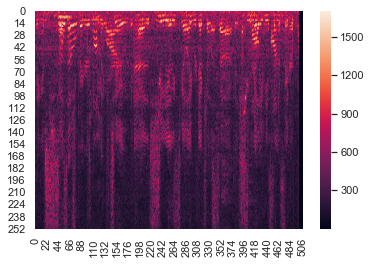

In [13]:
ax = sns.heatmap(np.rollaxis(useful_frames,1,0))

# Binary Mask Generation

In [181]:
def downsampling(samples, sample_rate, downsample_rate):
    secs = len(samples) / float(sample_rate)
    num_samples = int(downsample_rate * secs)

    return signal.resample(samples, num_samples)

In [183]:
# TF constants definition
TF_INTRA_OP_PT = int(os.getenv('TF_INTRA_OP', 0))
TF_INTER_OP_PT = int(os.getenv('TF_INTER_OP', 0))


def ltass_speaker(audio_folder, sample_rate=16e3, max_audio_length=48000, window_size=25, step_size=10, n_samples=1000):
    """
    Compute the speaker Long-Term Average Speech Spectrum of a speaker.
    """
    audio_filenames = sorted(glob(join(audio_folder, '*.wav')))
    
    audio_samples = np.zeros((len(audio_filenames), max_audio_length))
    num_frames = np.zeros(len(audio_filenames), dtype=np.int32)
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    for i, wav_file in enumerate(audio_filenames):
        rate, samples = wavfile.read(wav_file)
        samples = downsampling(samples, rate, sample_rate)
        audio_samples[i, :len(samples)] = samples
        num_frames[i] = len(samples) // step_frame_size
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_samples, dtype=tf.float32)
        # Compute STFT
        specs_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size, pad_end=False)
        # Apply power-law compression
        specs_tensor = tf.abs(specs_tensor) ** 0.3
        
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False,
                                              intra_op_parallelism_threads=TF_INTRA_OP_PT,
                                              inter_op_parallelism_threads=TF_INTER_OP_PT)) as sess:
            specs = sess.run(specs_tensor)

    spectrograms = []
    for spec, nf in zip(specs, num_frames):
        spectrograms.append(spec[:nf])
    
    flat_specs = np.vstack(spectrograms)
    mean_spec = flat_specs.mean(axis=0)
    stdev_spec = flat_specs.std(axis=0)
    
    return mean_spec, stdev_spec, specs


def compute_tbm(audio_folder, mask_threshold, sample_rate=16e3, max_audio_length=48000, n_fft=512, window_size=25, step_size=10):
    """
    Compute TBMs using LTASS.
    """
    audio_filenames = sorted(glob(join(audio_folder, '*.wav')))
    num_frames = np.zeros(len(audio_filenames), dtype=np.int32)
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_samples = np.zeros((len(audio_filenames), max_audio_length + n_fft//2))
    
    for i, wav_file in enumerate(audio_filenames):
        rate, samples = wavfile.read(wav_file)
        samples = downsampling(samples, rate, sample_rate)
        audio_samples[i, n_fft//2: len(samples) + n_fft//2] = samples
        num_frames[i] = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_samples, dtype=tf.float32)
        # Compute STFT
        specs_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size, pad_end=True)
        specs_tensor = tf.abs(specs_tensor)

        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False,
                                              intra_op_parallelism_threads=TF_INTRA_OP_PT,
                                              inter_op_parallelism_threads=TF_INTER_OP_PT)) as sess:
            specs = sess.run(specs_tensor)
            
    masks = specs > mask_threshold
    
    return audio_filenames, masks, num_frames


def save_target_binary_masks_speaker(audio_folder, mask_folder, mask_factor=0.5, sample_rate=16e3, max_audio_length=48000, ltass_samples=1000):
    # Create destination directory if not exists
    if not os.path.isdir(mask_folder):
        os.makedirs(mask_folder)
    
    # Compute thresholds and spectrograms
    print('Computing LTASS threshold...')
    threshold_mean, threshold_std, _ = ltass_speaker(audio_folder, sample_rate, max_audio_length=max_audio_length, n_samples=ltass_samples)
    # Denormalize
    threshold_freq = (threshold_mean + threshold_std * mask_factor) ** (1 / 0.3)
    print('done.')
    print('Threshold shape:', threshold_freq.shape)
    
    # Compute binary masks
    audio_filenames, masks, num_frames = compute_tbm(audio_folder, threshold_freq, sample_rate, max_audio_length=max_audio_length)

    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)

    for a_file, mask, nf in zip(audio_filenames, masks, num_frames):
        s_file = os.path.join(mask_folder, os.path.basename(a_file).replace('.wav', '.npy'))
        np.save(s_file, mask[:nf])
            
    print('Done. Target Binary Masks generated:', len(audio_filenames))


def save_target_binary_masks(dataset_path, list_of_speakers, audio_folder, dest_dir, mask_factor=0.5, sample_rate=16e3, max_audio_length=48000, ltass_samples=1000):
    for s in list_of_speakers:
        print('Computing Target Binary Masks of speaker {:d}...'.format(s))
        audio_path = os.path.join(dataset_path, 's' + str(s), audio_folder)
        dest_path = os.path.join(dataset_path, 's' + str(s), dest_dir)
        
        save_target_binary_masks_speaker(audio_path, dest_path, mask_factor, sample_rate, max_audio_length, ltass_samples)

        print('Speaker {:d} completed.'.format(s))

In [ ]:
# For single audio file

def ltass_speaker(audio_file, sample_rate=16e3, max_audio_length=48000, window_size=25, step_size=10, n_samples=1000):
    """
    Compute the speaker Long-Term Average Speech Spectrum of a speaker.
    """
    
    audio_sample = np.zeros((max_audio_length))
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_sample[:len(samples)] = samples
    num_frames = len(samples) // step_frame_size
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_sample, dtype=tf.float32)
        # Compute STFT
        spec_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size, pad_end=False)
        # Apply power-law compression
        spec_tensor = tf.abs(spec_tensor) ** 0.3
        
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False,
                                              intra_op_parallelism_threads=TF_INTRA_OP_PT,
                                              inter_op_parallelism_threads=TF_INTER_OP_PT)) as sess:
            spec = sess.run(spec_tensor)

    spectrogram = spec[:nf]
    
    mean_spec = spectrogram.mean()
    stdev_spec = spectrogram.std()
    
    return mean_spec, stdev_spec, spec


def compute_tbm(audio_file, mask_threshold, sample_rate=16e3, max_audio_length=48000, n_fft=512, window_size=25, step_size=10):
    """
    Compute TBMs using LTASS.
    """
    #audio_filenames = sorted(glob(join(audio_folder, '*.wav')))
    #num_frames = np.zeros(len(audio_filenames), dtype=np.int32)
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_sample = np.zeros((max_audio_length + n_fft//2))
    
    #for i, wav_file in enumerate(audio_filenames):
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_sample[n_fft//2: len(samples) + n_fft//2] = samples
    num_frames = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_sample, dtype=tf.float32)
        # Compute STFT
        spec_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size, pad_end=True)
        spec_tensor = tf.abs(spec_tensor)

        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False,
                                              intra_op_parallelism_threads=TF_INTRA_OP_PT,
                                              inter_op_parallelism_threads=TF_INTER_OP_PT)) as sess:
            spec = sess.run(spec_tensor)
            
    mask = spec > mask_threshold
    
    return audio_file, mask, num_frames

def save_target_binary_mask_speaker(audio_file, mask_file, mask_factor=0.5, sample_rate=16e3, max_audio_length=48000, ltass_samples=1000):
    
    # Compute thresholds and spectrograms
    print('Computing LTASS threshold...')
    threshold_mean, threshold_std, _ = ltass_speaker(audio_file, sample_rate, max_audio_length=max_audio_length, n_samples=ltass_samples)
    # Denormalize
    threshold_freq = (threshold_mean + threshold_std * mask_factor) ** (1 / 0.3)
    print('done.')
    print('Threshold shape:', threshold_freq.shape)
    
    # Compute binary masks
    audio_filename, mask, num_frames = compute_tbm(audio_file, threshold_freq, sample_rate, max_audio_length=max_audio_length)

    #for a_file, mask, nf in zip(audio_filenames, masks, num_frames):
    s_file = os.path.join(audio_file[:-3]+'.npy')
    np.save(s_file, mask[:nf])
            
    print('Done. Target Binary Masks generated:', len(audio_filenames))

# Organising Files and extracting audio

In [18]:
# To read the images in numerical order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [48]:
files = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/pretrain/*/*.mp4'), key=numericalSort)

In [23]:
files_split = []
for i in files:
    files_split.append(i.split('/'))

In [118]:
len(files)

238

In [46]:
# Extract audio and save as .wav files 

def get_wav(mp4_file):
    
    out_path = mp4_file[:-3]+"wav"
    command = "ffmpeg -i " + mp4_file + ' -codec:a' + ' pcm_s16le' + ' -ac' + ' 1 ' + out_path
    subprocess.call(command, shell=True)

In [129]:
# From all the existing files, pick certain number files randomly and pair certain number of them together. (Just the file names)
def pair_files(files, combination_no=1, count=10):
    
    if combination_no <= 0 or count <= 0:
        print('Inputs not valid')
        return 0
    
    combined_list = []
    
    picks_no = combination_no*count
    
    for item in files:
        
        files_copy = files
        
        if len(combined_list)>0:
            if combination_no == 1:
                for done in combined_list:
                    if item in done:
                        index = done.index(item)
                        del_index = int(not index)
                        del_file = done[del_index]
                        files_copy.remove(del_file)
        
        random.seed(1)
        picks = random.sample(files_copy, picks_no)
        
        for i in range(count):
            
            if combination_no == 1:
                random.seed(2)
                picked = random.sample(picks, combination_no)
                
                combined = [0]*2
                combined[0] = item
                combined[1] = picked

                picks = [e for e in picks if e is not picked]
                
            else:
                
                random.seed(3)
                picked = random.sample(picks, combination_no)
                
                picks = [e for e in picks if e is not picked]
                
                picked.append(item)
                
                combined = picked
                
            combined_list.append(combined)
            
    return combined_list

In [139]:
combined_list = pair_files(files, combination_no=4, count=10)

In [140]:
combined_list[1]

['/Users/manideepkolla/Downloads/test_fold/pretrain/5957285425744490519/00062.mp4',
 '/Users/manideepkolla/Downloads/test_fold/pretrain/5549779787693549159/00010.mp4',
 '/Users/manideepkolla/Downloads/test_fold/pretrain/5971440779089133573/00031.mp4',
 '/Users/manideepkolla/Downloads/test_fold/pretrain/6077451309242250656/00026.mp4',
 '/Users/manideepkolla/Downloads/test_fold/pretrain/5549779787693549159/00001.mp4']

In [123]:
len(combined_list)

2380

# Generate final Training/Val/Testing folders

### Directory structure

```
TRAINING_SET

    s1_1
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    s1_2
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    ...
    
    s2_1
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    s2_2
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    ...

```

In [150]:
# Generate training folders for one combination

def gen_comb_folders(combined_pairs, dest_folder):
    
    try:
        os.mkdir(dest_folder)
    except OSError:
        pass

    videos = combined_pairs
    audios = []
    
    for item in videos:
        audio = item[:-3] + 'wav'
        audios.append(audio)
        
    video_audio = [[0]*2]*len(combined_pairs)
    
    for i in range(len(video_audio)):
        video_audio[i][0] = videos[i]
        video_audio[i][1] = audios[i]
        
    # Folder to save the files
    
    folder_name = videos[-1].split()[-2] + '_' + videos[-1].split()[-1]
    folder_path = dest_folder + '/' + folder_name
        
    spectrograms = []
    masks = []
    frames = []
    for item in video_audio:
        video = item[0]
        audio = item[1]
        
        # Get frames
        frame=get_video_frames(video)
        mouth=get_frames_mouth(detector, predictor, frames)
        
        frames.append(mouth)
        
        # Compute Spectrograms
        
        # Extract audio save as .wav
        get_wav(video)
        
        s,n=compute_spectrograms(audio) ## Need to compute (remaining)
        useful_frames=s[0][:n,:] ## Need to compute (remaining)
        
        spectrograms.append(useful_frames)
        
        # Compute masks
        
        mask = 0        ## Need to compute (remaining)
        
        masks.append(mask) 
        
        ## Now mix the audios and compute the spectrogram of mixed audio
        
        mixed_spectogram =          ## Remaining
        
        
        for p in len(video_audio):
            
            frame = frames[p]
            mask = masks[p]
            
            try:
                os.mkdir(folder_path + '_' + str(p))
            except OSError:
                pass
            
            # Save lips.mp4
            
            outputdata = np.asarray(frame)
            writer = skvideo.io.FFmpegWriter(folder_path + '_' + str(p)+ '/' + 'lips.mp4')
            for i in range(outputdata.shape[0]):
                writer.writeFrame(outputdata[i, :, :, :])
            writer.close()
            
            # Save the mask
            mask = Image.fromarray(mask)
            mask = mask.convert('RGB')
            im.save(folder_path + '_' + str(p)+ '/' + 'mask.png')
            
            # Save the mixed spectrogram
            mix_spect = Image.fromarray(mixed_spectogram)
            mix_spect = mix_spect.convert('RGB')
            im.save(folder_path + '_' + str(p)+ '/' + 'mixed_spectrogram.png')

In [167]:
A = np.random.rand(10,10)
im = Image.fromarray(A)
im = im.convert('RGB')
im.save("your_file.png")

In [169]:
frames=get_video_frames('/Users/manideepkolla/Downloads/test_fold/pretrain/5957285425744490519/00062.mp4')

In [170]:
len(frames)

271

In [171]:
get_wav('/Users/manideepkolla/Downloads/test_fold/pretrain/5957285425744490519/00062.mp4')

In [173]:
s,n=compute_spectrograms('/Users/manideepkolla/Downloads/test_fold/pretrain/5957285425744490519/00062.wav', max_audio_length=200000)

In [178]:
s.shape

(1, 1252, 257)

In [176]:
useful_frames=s[0][:n,:]

In [177]:
useful_frames.shape

(1090, 257)

In [187]:
np.asarray([[1,2,3], [4,5,6]]).mean()

3.5

start = time.time()
mouth=get_frames_mouth(detector, predictor, frames)
end = time.time()
print((end-start))

outputdata = np.asarray(mouth)

writer = skvideo.io.FFmpegWriter("outputvideo.mp4")
for i in range(outputdata.shape[0]):
        writer.writeFrame(outputdata[i, :, :, :])
writer.close()